FOR ORAL CANCER PREDICTION


In [68]:
import glob
import numpy as np
from PIL import Image
from numpy import array
from keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
import keras as k
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn
from sklearn.metrics import confusion_matrix , classification_report
import joblib
import warnings

from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")

In [69]:
cancer_imgs = glob.glob('../Dataset/OralCancer/cancer' + '/*.jpg')
non_cancer_imgs = glob.glob('../Dataset/OralCancer/non-cancer/' + '/*.jpg')

In [70]:
dataset = []
labels = []

for img in cancer_imgs:
  dataset.append(image.img_to_array(image.load_img(img, target_size=(64, 64))))
  labels.append(1)

for img in non_cancer_imgs:
  dataset.append(image.img_to_array(image.load_img(img, target_size=(64, 64))))
  labels.append(0)
  
dataset = array(dataset)

Cancer Images: 


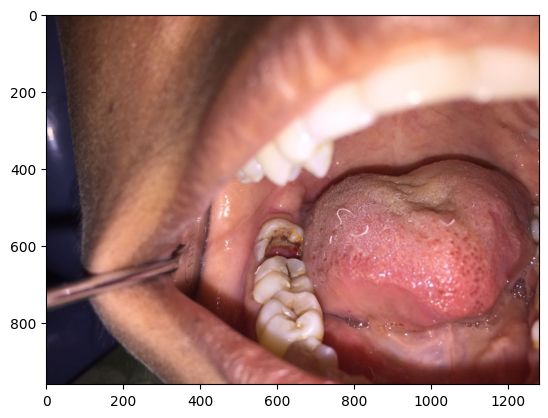

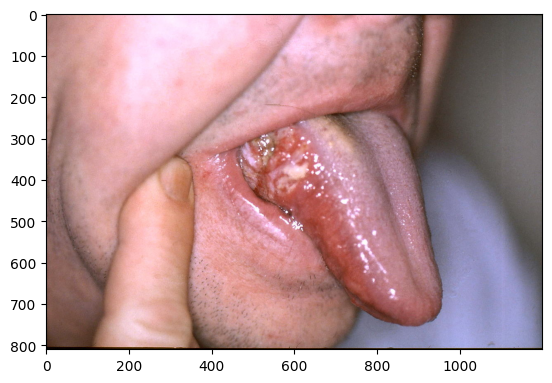

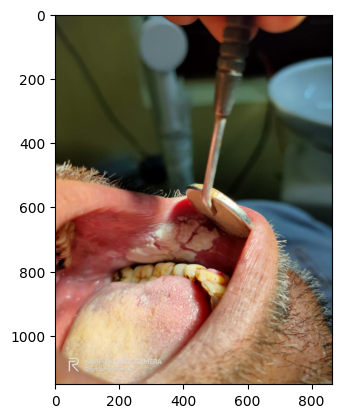

In [71]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline


print('Cancer Images: ')
for img in cancer_imgs[:3]:
  testim = mpimg.imread(img)
  plt.figure()
  imshow(testim)

In [72]:
def evaluate_model(clf, X_test, y_test, model_name):
  print('--------------------------------------------')
  print('Model ', model_name)
  y_pred = clf.predict(X_test)
  f1 = f1_score(y_test, y_pred.round(), average='weighted')
  recall = recall_score(y_test, y_pred.round(), average='weighted')
  precision = precision_score(y_test, y_pred.round(), average='weighted')
 # print(classification_report(y_test, y_pred.round()))
  print("F1 Score ", f1)
  print("Recall ", recall)
  print("Precision ", precision)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, random_state=42)
X_train = X_train.reshape(len(X_train),3*64*64)
X_test = X_test.reshape(len(X_test),3*64*64)

In [40]:

oc_clf_tree = tree.DecisionTreeClassifier(random_state=42)
oc_clf_tree = oc_clf_tree.fit(X_train, y_train)

In [41]:

sc = StandardScaler()
X2_train = sc.fit_transform(X_train)
X2_test = sc.transform(X_test)
oc_rf = RandomForestClassifier(n_estimators=2000,criterion='entropy', random_state=0)
oc_rf.fit(X2_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=2000, random_state=0)

In [42]:

oc_svm = svm.SVC(kernel='poly') # Linear Kernel
oc_svm.fit(X_train, y_train)

SVC(kernel='poly')

In [43]:
evaluate_model(oc_clf_tree, X_test, y_test, 'Decision Tree')


--------------------------------------------
Model  Decision Tree
              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.76      0.81      0.79        16

    accuracy                           0.72        25
   macro avg       0.69      0.68      0.69        25
weighted avg       0.71      0.72      0.72        25

F1 Score  0.7160071301247772
Recall  0.72
Precision  0.7144117647058823


In [44]:
evaluate_model(oc_rf, X2_test, y_test, 'RandomForest')


--------------------------------------------
Model  RandomForest
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.93      0.88      0.90        16

    accuracy                           0.88        25
   macro avg       0.87      0.88      0.87        25
weighted avg       0.89      0.88      0.88        25

F1 Score  0.8812224108658744
Recall  0.88
Precision  0.8853333333333333


In [45]:
evaluate_model(oc_svm, X_test, y_test, 'SVM')

--------------------------------------------
Model  SVM
              precision    recall  f1-score   support

           0       0.62      0.89      0.73         9
           1       0.92      0.69      0.79        16

    accuracy                           0.76        25
   macro avg       0.77      0.79      0.76        25
weighted avg       0.81      0.76      0.76        25

F1 Score  0.7646753246753246
Recall  0.76
Precision  0.8082051282051281


In [85]:

def load_and_convert_to_gray(img_path):
    img = Image.open(img_path).convert('L')  # 'L' mode stands for grayscale
    img_array = image.img_to_array(img.resize((64, 64)))  # Resize to desired dimensions
    return img_array

dataset = []
labels = []


for img in cancer_imgs:
    img_array = load_and_convert_to_gray(img)
    dataset.append(img_array)
    labels.append(1)

for img in non_cancer_imgs:
    img_array = load_and_convert_to_gray(img)
    dataset.append(img_array)
    labels.append(0)

dataset = array(dataset)
labels = np.array(labels)
labels_one_hot = to_categorical(labels, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels_one_hot, test_size=0.3, random_state=42)

time_steps = X_train.shape[1]
features = X_train.shape[2]

lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(time_steps, features), activation='relu', return_sequences=True))
lstm_model.add(LSTM(16, activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss_lstm:.4f}, Test Accuracy: {accuracy_lstm:.4f}')

evaluate_model(lstm_model, X_test, y_test, "LSTM")


Epoch 1/30
3/3 [==============================] - 3s 205ms/step - loss: 153.6504 - accuracy: 0.4571 - val_loss: 84.8686 - val_accuracy: 0.7333
Epoch 2/30
3/3 [==============================] - 0s 49ms/step - loss: 206.4990 - accuracy: 0.4571 - val_loss: 58.7334 - val_accuracy: 0.6000
Epoch 3/30
3/3 [==============================] - 0s 46ms/step - loss: 223.5976 - accuracy: 0.5429 - val_loss: 790.0165 - val_accuracy: 0.5333
Epoch 4/30
3/3 [==============================] - 0s 45ms/step - loss: 230.1939 - accuracy: 0.5571 - val_loss: 286.6631 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 0s 41ms/step - loss: 298.3623 - accuracy: 0.4429 - val_loss: 66.1754 - val_accuracy: 0.7333
Epoch 6/30
3/3 [==============================] - 0s 50ms/step - loss: 179.7113 - accuracy: 0.5714 - val_loss: 251.6214 - val_accuracy: 0.4000
Epoch 7/30
1/1 [==============================] - 0s 34ms/step - loss: 58.7334 - accuracy: 0.6000
Test Loss: 58.7334, Test Accuracy: 0.6000
----

In [61]:
#import our data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,rotation_range=10, fill_mode='nearest',
     featurewise_center=True,
    featurewise_std_normalization=True,
    vertical_flip= True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = (0.4,0.6),
    horizontal_flip=True,validation_split=0.3)

In [62]:
train_generator = train_datagen.flow_from_directory(
    '../Dataset/OralCancer/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='training'
  )

Found 92 images belonging to 2 classes.


In [63]:
test_generator = train_datagen.flow_from_directory(
     '../Dataset/OralCancer/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='validation'
    
  )

Found 39 images belonging to 2 classes.


Found 131 files belonging to 2 classes.


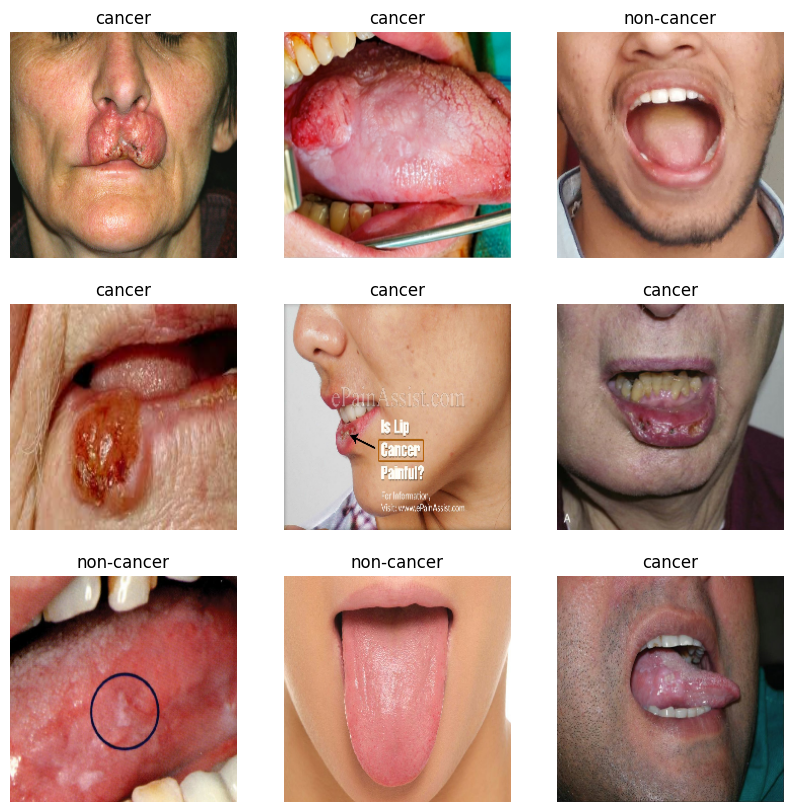

In [64]:
train_dataset = image_dataset_from_directory('../Dataset/OralCancer/',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [ ]:
res_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=k.Input(shape=(224,224,3)),
)
for models in res_model.layers[:-1]:
      models.trainable= False
model = k.models.Sequential()
model.add(res_model)
model.add(k.layers.Flatten())
model.add(k.layers.Dense(4, activation='softmax'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 4)                 401412    
                                                                 
Total params: 23989124 (91.51 MB)
Trainable params: 401412 (1.53 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
None


In [ ]:
model.compile(optimizer="adam", loss=k.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
FIT =model.fit(train_generator,
    validation_data = test_generator, 
    callbacks = [early],
    epochs = 5)

Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 1.5316 - accuracy: 0.4239 - val_loss: 1.5618 - val_accuracy: 0.6667
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 1.7028 - accuracy: 0.5326 - val_loss: 0.6607 - val_accuracy: 0.6667
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.4373 - accuracy: 0.6630 - val_loss: 0.8254 - val_accuracy: 0.6667
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 0.7382 - accuracy: 0.5870 - val_loss: 0.6444 - val_accuracy: 0.6667
Epoch 5/5
3/3 [==============================] - 9s 3s/step - loss: 0.6547 - accuracy: 0.6630 - val_loss: 0.6661 - val_accuracy: 0.5385


In [ ]:
class_name = {0:"cancer",1:"non cancer"}

In [ ]:
y = model.predict(test_generator)
y =  np.argmax(y,axis= 1 )

2/2 [==============================] - 4s 323ms/step


In [ ]:
y_true = np.array([])
y_pred = np.array([])

i = 0
for data, labels in test_generator:
    i += 1
    y = np.argmax(model.predict(data), axis=1)
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, y)
  
    if i == test_generator.samples // 32 + 1:
        break

1/1 [==============================] - 1s 1s/step


In [ ]:
f1 = f1_score(y_pred, y_true, average='weighted')
precision = precision_score(y_pred, y_true, average='weighted')
print("F1 Score ", f1)
print("Precision ", precision)

F1 Score  0.5502201502201501
Precision  0.8688362919132151


In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Define the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=test_generator, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred = (model.predict(test_generator) > 0.5).astype("int32")

f1 = f1_score(y_pred, y_true, average='weighted')
precision = precision_score(y_pred, y_true, average='weighted')
recall=recall_score(y_pred, y_true, average='weighted')
print("F1 Score ", f1)
print("Precision ", precision)
print("Recall score",recall)

Epoch 1/15
3/3 [==============================] - 6s 2s/step - loss: 1.5808 - accuracy: 0.5217 - val_loss: 0.8804 - val_accuracy: 0.6667
Epoch 2/15
3/3 [==============================] - 4s 1s/step - loss: 1.2913 - accuracy: 0.5870 - val_loss: 0.6010 - val_accuracy: 0.6667
Epoch 3/15
3/3 [==============================] - 4s 1s/step - loss: 1.0068 - accuracy: 0.6739 - val_loss: 0.6463 - val_accuracy: 0.6923
Epoch 4/15
3/3 [==============================] - 4s 1s/step - loss: 0.7972 - accuracy: 0.6957 - val_loss: 0.6720 - val_accuracy: 0.7436
Epoch 5/15
3/3 [==============================] - 4s 1s/step - loss: 0.5656 - accuracy: 0.7283 - val_loss: 0.6893 - val_accuracy: 0.5641
Epoch 6/15
3/3 [==============================] - 4s 1s/step - loss: 0.4848 - accuracy: 0.7609 - val_loss: 0.7032 - val_accuracy: 0.2821
Epoch 7/15
2/2 [==============================] - 1s 48ms/step - loss: 0.6313 - accuracy: 0.6667
Test Loss: 0.6313, Test Accuracy: 0.6667
2/2 [==============================] - 1

In [103]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Assuming 'train_generator' is used for training and 'test_generator' for testing
# Assuming you have determined 'num_classes' based on your data
num_classes = 2

# Build the EfficientNetB3 model
efficientnet_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in efficientnet_model.layers:
    layer.trainable = False

# Build your model on top of EfficientNetB3
model = Sequential()
model.add(efficientnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=test_generator, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=-1)
print(classification_report(test_generator.classes, y_pred_classes, target_names=class_name))


Epoch 1/15
3/3 [==============================] - 19s 4s/step - loss: 0.6757 - accuracy: 0.6413 - val_loss: 0.6967 - val_accuracy: 0.6667
Epoch 2/15
3/3 [==============================] - 7s 3s/step - loss: 0.6900 - accuracy: 0.5217 - val_loss: 0.7150 - val_accuracy: 0.3333
Epoch 3/15
3/3 [==============================] - 7s 3s/step - loss: 0.6757 - accuracy: 0.5652 - val_loss: 0.6394 - val_accuracy: 0.6667
Epoch 4/15
3/3 [==============================] - 7s 3s/step - loss: 0.6638 - accuracy: 0.6630 - val_loss: 0.6743 - val_accuracy: 0.6667
Epoch 5/15
3/3 [==============================] - 7s 3s/step - loss: 0.6727 - accuracy: 0.6630 - val_loss: 0.6398 - val_accuracy: 0.6667
Epoch 6/15
3/3 [==============================] - 7s 3s/step - loss: 0.6389 - accuracy: 0.6630 - val_loss: 0.6674 - val_accuracy: 0.6667
Epoch 7/15
3/3 [==============================] - 7s 3s/step - loss: 0.6685 - accuracy: 0.6630 - val_loss: 0.6534 - val_accuracy: 0.6667
Epoch 8/15
3/3 [========================

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Assuming 'train_generator' is used for training and 'test_generator' for testing
# Assuming you have determined 'num_classes' based on your data
num_classes = 2

# Build the VGG19 model
vgg19_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in vgg19_model.layers:
    layer.trainable = False

# Build your model on top of VGG19
model = Sequential()
model.add(vgg19_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=-1)
print(classification_report(test_generator.classes, y_pred_classes, target_names=class_name))
